In [24]:
import os

In [25]:
from __future__ import print_function
import time
import random
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
import matplotlib.animation as animation
from skimage import io,transform
from IPython.display import HTML
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm
import wallhavendataset

import nets 

from embedding import SentEmbedding,GloveEmbedding
import glob

In [26]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Hyperparameters

In [33]:
#Root directory for dataset
dataroot = "./DatasetWHScrapper/Wallhaven/"
#dataroot = "./DatasetWHScrapper/lhq/lhq_256/LHQ256/"
# Number of workers for the loader
workers = 5
#Barch Size during training
batch_size = 32
#Spatial size of training images.
image_size=64
#Number of channels in the training images
nc=3
#Size of z latent vector(i.e. size of generator input)
nz = 100
#Size of feature maps in generator
ngf = 64
#Size of feature maps in discriminator
ndf = 64
#Number of training epoch
num_epochs = 200
#Learning rate for optimizers
lr = 0.0002
#beta1 hyperparam for Adam optimizer
beta1 = 0.5
#Dimensions of sentence embedding
embed_dim = 100
projected_embed_dim = 64


#Number of GPUs available
ngpu = 1
#Device used
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu>0) else "cpu")


# Nets

In [28]:
netG = nets.createNet("generator", device,  ngpu, nc, ngf,  embed_dim, projected_embed_dim, nz,verbose=True)
netD = nets.createNet("discriminator", device,  ngpu, nc, ngf, embed_dim, projected_embed_dim, verbose=True)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(164, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
  

In [29]:
embedder = GloveEmbedding()
embedder.create_vocabulary()

cuda
6412
['lake', 'desert', 'night', 'beach', 'desert', 'glacier', 'lake', 'night', 'night', 'river', 'forest', 'lake', 'river', 'glacier', 'glacier', 'mountain', 'lake', 'river', 'sun', 'mountain', 'jungle', 'night', 'forest', 'jungle', 'forest', 'mountain', 'forest', 'jungle', 'forest', 'beach', 'forest', 'grass']


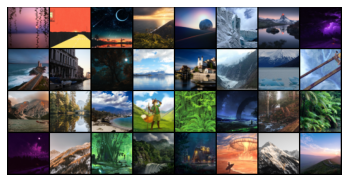

In [30]:
import importlib
importlib.reload(wallhavendataset)
from wallhavendataset import *
dataset = Text2ImageDataset(root=dataroot,
                           transform=transforms.Compose([
                              Rescale(image_size),
                              CenterCrop(image_size),
                              EmbedLabel(embedder),
                              ToTensor(), 
                          ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                        shuffle=True, num_workers=0)

print(device.type)
print(len(dataset))
real_batch = next(iter(dataloader))
plt.axis("off")
for i_batch, sample_batched in enumerate(dataloader):
    # observe 4th batch and stop.
    if i_batch == 3:
        show_landmarks_batch(sample_batched)

        plt.show()
        break
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

# Loss functions and Optimizers

In [31]:
#Initialize BCELoss function 
criterion = nn.BCELoss()

#Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(5, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

#Setup Adam optimizers for G and D
optimizerD= optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG= optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training

In [34]:
import importlib
importlib.reload(nets)

trainer = nets.GANTrainer(netG, netD, dataloader, embedder, optimizerD, optimizerG, criterion)
netG, netD, G_losses, D_losses = trainer.run(num_epochs=num_epochs, device=device, nz=nz)

[0/200][0/201]	Loss_D: 1.6987	Loss_G: 6.9447	D(x): 0.4039	D(G(z)): 0.0061
[0/200][10/201]	Loss_D: 1.3117	Loss_G: 4.0550	D(x): 0.6361	D(G(z)): 0.2778
[0/200][20/201]	Loss_D: 1.4139	Loss_G: 1.8259	D(x): 0.5244	D(G(z)): 0.4342
[0/200][30/201]	Loss_D: 1.1542	Loss_G: 2.3528	D(x): 0.4602	D(G(z)): 0.1711
[0/200][40/201]	Loss_D: 1.3033	Loss_G: 2.6499	D(x): 0.5594	D(G(z)): 0.4816
[0/200][50/201]	Loss_D: 1.1778	Loss_G: 3.6092	D(x): 0.6610	D(G(z)): 0.2784
[0/200][60/201]	Loss_D: 1.3064	Loss_G: 2.6087	D(x): 0.6448	D(G(z)): 0.4301
[0/200][70/201]	Loss_D: 1.1626	Loss_G: 2.3990	D(x): 0.4990	D(G(z)): 0.1774
[0/200][80/201]	Loss_D: 1.2332	Loss_G: 2.4779	D(x): 0.5789	D(G(z)): 0.3399
[0/200][90/201]	Loss_D: 1.2618	Loss_G: 3.4677	D(x): 0.6287	D(G(z)): 0.3680
[0/200][100/201]	Loss_D: 1.0905	Loss_G: 3.4040	D(x): 0.5666	D(G(z)): 0.2023
[0/200][110/201]	Loss_D: 1.3904	Loss_G: 1.9641	D(x): 0.3769	D(G(z)): 0.0936
[0/200][120/201]	Loss_D: 1.2787	Loss_G: 2.5812	D(x): 0.5887	D(G(z)): 0.3217
[0/200][130/201]	Loss_D

# Loss vs training iteration

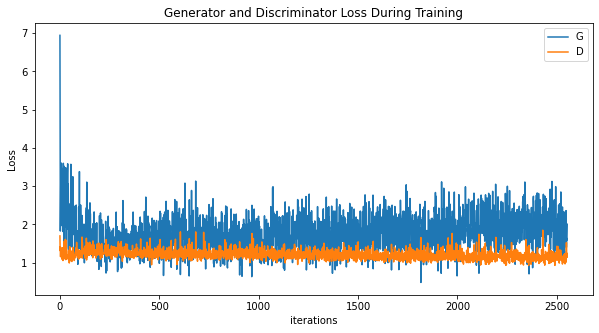

In [35]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualization of G's progression

NameError: name 'img_list' is not defined

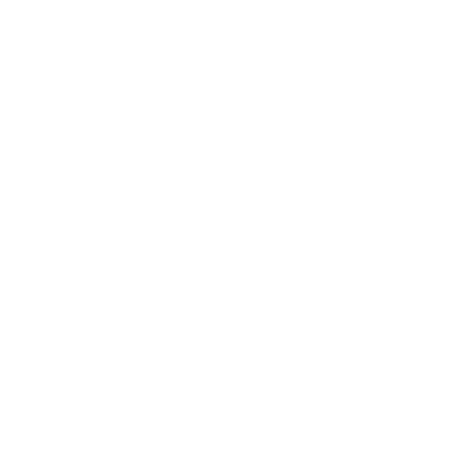

In [ ]:
img_list=[]

check = torch.from_numpy(embedder.embed(["glacier", "river", "mountain","sea", "mountain"])).to(device)

fake = netG(fixed_noise, check).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]